All input audio files are sampled at 44.1 kHz but are of varying durations (from 1second to 26 seconds). The inputs are given as time domain signals. A clip of duration 1 second is represented by a vector of size 44100. Also, inputs are of varying size.Test samples could as well be of varying durations.\
Inorder to process all inputs with the same system, we have to either:\
a)Standardise input size, or\
b)Neural architecture that is able to process inputs of varying size.

Here, we have chose to standardise the input size.

# TRAINING PHASE

# Data Preprocessing

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import os

!pip install librosa

In [ ]:
#Please update with path to "challenge_dataset" folder.
base_dir = '/content/drive/MyDrive/IE643_Challenge/challenge_dataset.zip (Unzipped Files)/challenge_dataset'

Train_Val-Test Split:\
1 random samples from each class is included in the test set to give a total of 7 test samples. Similarly 1 sample from each class is included in the validation set.

In [ ]:
%%time

#Code to split the entire dataset into train_val and test sets.
tot_data=[]
train_val=[]
test=[]
np.random.seed(0)

for file in os.listdir(base_dir):
  label=int(file)-1       #target labels are shifted to 0, 1, 2,... 6
  ind_class=[]
  for sample in os.listdir(os.path.join(base_dir, file)):
    audio_file=librosa.load(os.path.join(base_dir, file, sample), sr=None)      #Sampling rate is the default sampling rate used in the .wav input file

    if audio_file[1] != 44100:
      print('Sample rate of sample{} is not 44.1 kHz, it is {}'.format(i, rate))

    ind_class.append([[audio_file[0], audio_file[1]], label])     #audio_file[0]---numpy array containing audio, audio_file[1]---sampling rate of the audio clip
  np.random.shuffle(ind_class)
  tot_data.append(ind_class)
  train_val.append(ind_class[:16])
  test.append(ind_class[16:])


CPU times: user 120 ms, sys: 112 ms, total: 232 ms
Wall time: 447 ms


All input audio files are sampled at 44.1 kHz.

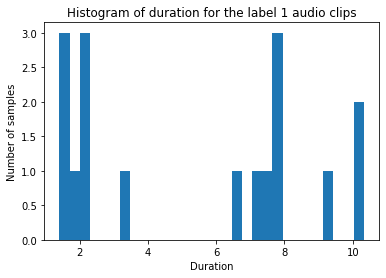

Average duration 5.277472322262237


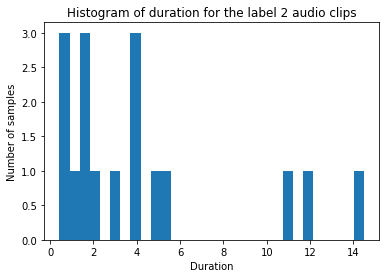

Average duration 4.231643323996265


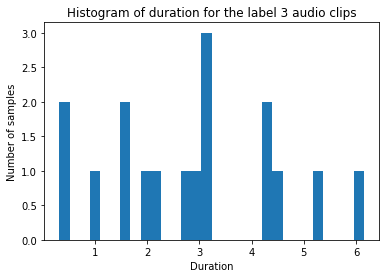

Average duration 2.8626437241563294


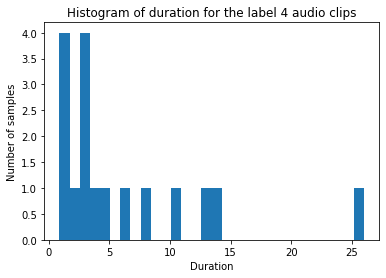

Average duration 6.164189675870348


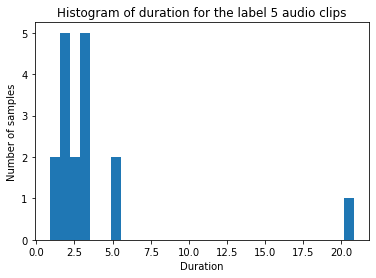

Average duration 3.740524209683873


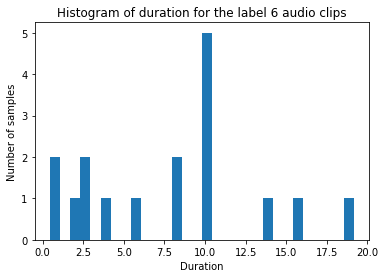

Average duration 7.8479298386021075


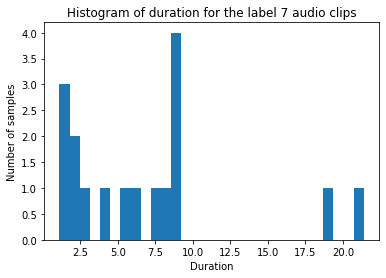

Average duration 6.929108976924103


In [ ]:
#Code to display the duration of clips for each label
tot_list=[]
for i in range(len(tot_data)):
  dur_list=[]
  for aud in (tot_data[i]):
    dur=librosa.get_duration(aud[0][0], aud[0][1])
    dur_list.append(dur)
    tot_list.append(dur)
  
  plt.hist(dur_list, bins=30)
  plt.title('Histogram of duration for the label {} audio clips'.format(i+1))
  plt.xlabel('Duration')
  plt.ylabel('Number of samples')
  plt.show()
  print('Average duration', np.mean(np.asarray(dur_list)))



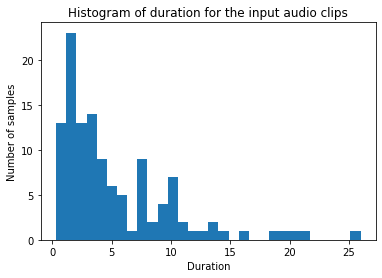

In [ ]:
#Code to display the duration of clips for entire dataset.
plt.hist(tot_list, bins=30)
plt.title('Histogram of duration for the input audio clips')
plt.xlabel('Duration')
plt.ylabel('Number of samples')
plt.show()

In [ ]:
print('Number of train_validation samples', sum( [ len(label_count) for label_count in train_val]))
print('Number of test samples', sum( [ len(label_count) for label_count in test]))

Number of train_validation samples 112
Number of test samples 7


In [ ]:
#To split the train_val into separate train and validation sets. It could be used for other validation strategies as well:
def gen_train_val_split(dset):
  train_set=[]
  val_set=[]
  for ind_class in dset:
    #np.random.shuffle(ind_class)
    train_set.append(ind_class[:15])
    val_set.append(ind_class[15:])
  return train_set, val_set


In [ ]:
#creating training set and validation set.
train_set, val_set=gen_train_val_split(train_val)

In [ ]:
#audio_file---[audio_file[0], audio_file[1]]---audio_file[0]: numpy array audio signal in time domain sampled at audio_file[1]: sampling rate
def play(audio_file):
   return ipd.Audio(audio_file[0], rate=audio_file[1])

Consider a sample from label '1' (actual label '2').

In [ ]:
play(train_set[1][13][0])          #train_val['label']['sample_number'][0---audio_file]

Data preprocessing:\
It is observed that most of the audio samples have leading, trailing and intermediary silence. This will be trimmed.\
Input size will be standardised.\
Hyperparameter time_res is introduced.\
This refers to the duration of the audio clips (seconds) that will be fed to the neural network.\
This hopes to be the shortest time interval that can capture the discerning features of any of the classes.\
NOTE: The mfcc of the signals are fed to the network.


In [ ]:
!pip install audiomentations
!pip install pydub

In [ ]:
#could be used for augmentation
from audiomentations import Compose, AddGaussianNoise, PitchShift, Shift

augment = Compose([
    AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.02, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])


In [ ]:
from scipy.fft import fft

def preprocess(aud):
  #aud---[aud[0], aud[1]]--->aud[0]---numpy array containing audio file in time domain, aud[1]---sample rate]
  audio_feat=[]
  audio_clips=[]
  sample_count=0
  #Trimming audio file to remove leading, trailing and intermediate silence.
  audio_s = librosa.effects.split(aud[0], top_db=40)

  time_res=0.5
  f_l=int(time_res*44100)
  #Audio input to neural network is signals of time_res second duration sampled at 44.1 kHz.
  #If an input audio sample is less than 0.5 second duration, it is centered with zero padding to 0.5 seconds.
  for k in range(len(audio_s)):
    clip=aud[0][audio_s[k][0]:audio_s[k][1]]
    if (librosa.get_duration(clip, sr=aud[1]) >= time_res):
      stream = librosa.util.frame(clip, frame_length=f_l, hop_length=11025, axis=0)
    else:
      stream = librosa.util.pad_center(clip, f_l, mode='constant')
      stream = librosa.util.frame(stream, frame_length=f_l, hop_length=11025, axis=0)

    #0.5 second signals are seperated out with next sample beginning after a delay of 0.25 second.
    #For example, 1 second duration input audio clip will be partitioned into 3 samples ([0, 0.5], [0.25, 0.75], [0.5, 1]).
    #Number of cepstral coefficients considered are 40.
    for i in range(len(stream)):
      #feat=librosa.feature.mfcc(stream[i], sr=aud[1], n_mfcc=40)
      #stream[i]=augment(samples=stream[i], sample_rate=aud[1])
      feat=np.abs(fft(stream[i], norm='ortho' ))
      audio_feat.append((feat[:11025], aud[1]))
      audio_clips.append((stream[i], aud[1]))
      sample_count +=1
  
  return audio_feat, audio_clips, sample_count

In [ ]:
audio_feat, audio_clips, sample_count=preprocess(train_val[1][13][0])
print('For the given audio clip, {} input points are created.'.format(sample_count))

For the given audio clip, 8 input points are created.


In [ ]:
play(audio_clips[1])

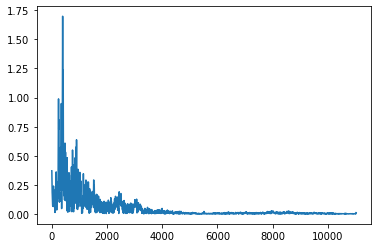

In [ ]:
#plot of amplitude of frequency spectrum
plt.plot(audio_feat[1][0])

Plot mfcc spectrum of entire class.

Some of the clips might be shorter than time_res.In such cases, the signal can either be padded or looped to the desired duration (time_res).

Even though the number of samples for each class is same, the total duration of the sound clips for each class vary.

In [ ]:
from torch.utils.data import Dataset

class AudioDataset(Dataset):
    def __init__(self, train_val, transform=None):
      audio_feat=[]
      audio_files=[]
      lbl_cnt=[]

      for categ in train_val:
        label_count=0
        for aud in categ:
          audio_feat_i, audio_files_i, sample_count=preprocess(aud[0])
          audio_feat_i=[[elem, aud[1]] for elem in audio_feat_i]
          audio_files_i=[[elem, aud[1]] for elem in audio_files_i]
          audio_feat= audio_feat + audio_feat_i
          audio_files= audio_files + audio_files_i
          label_count +=sample_count
        lbl_cnt.append(label_count)

      self.lbl_cnt=lbl_cnt   
      self.audio_feat=audio_feat
      self.audio_files=audio_files

  #def get_audioAndrate(self,index):


    def __getitem__(self, index):
      return self.audio_feat[index][0][0], self.audio_feat[index][1]
      #return prep_sample(self.audio_files[index]), self.audio_files[index][1]

    def __len__(self):
        return len(self.audio_feat)

In [ ]:
train_aud_set = AudioDataset(train_set)
val_aud_set = AudioDataset(val_set)

In [ ]:
train_aud_set.lbl_cnt

[239, 118, 120, 297, 76, 365, 322]

In [ ]:
class_sample_count=np.array(train_aud_set.lbl_cnt)
weight = 1. / class_sample_count

sample_weight=[]
for i in range(len(train_aud_set)):
  sample_weight.append(weight[train_aud_set[i][1]])
sample_weight=np.array(sample_weight)

sample_weight = torch.from_numpy(sample_weight)
wgt_sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weight, len(sample_weight))

In [ ]:
np.shape((train_aud_set[6][0]))

(11025,)

In [ ]:
from torch.utils.data import DataLoader

mb_size=512
trainLoader = torch.utils.data.DataLoader(train_aud_set,batch_size=mb_size, 
                                          sampler = wgt_sampler)

valLoader = torch.utils.data.DataLoader(val_aud_set,batch_size=1, 
                                          sampler = torch.utils.data.sampler.SequentialSampler(val_aud_set))

In [ ]:
import torch.nn as nn

class Audio_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear(11025, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 7),

        )

    def forward(self, input):
        return self.model(input)

In [ ]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(device)

cuda


In [ ]:
model=Audio_Net().to(device)

Adam optimiser is used for updating the gradients. (This was not mentioned in the report.)

In [ ]:
import torch.optim as opt

lr = 1e-3  #learning rate
#optimizers for both models
opt = opt.Adam(model.parameters(), lr=lr)

In [ ]:
criterion=nn.CrossEntropyLoss()

In [ ]:
def eval_acc(dset):
    ac_count=0
    for i in range(len(dset)):
      input=torch.tensor(dset[i][0]).to(device)
      input=input.view(-1)
      output=model(input)
      if torch.argmax(output).item() == dset[i][1] :
        ac_count+=1
    acc = (ac_count/len(dset))
    return acc



In [ ]:
train_acc=[]
val_acc=[]
train_loss=[]
val_loss=[]

In [ ]:
for epoch in range(50):

    loss_run_t = 0.0    
    for i, data in enumerate(trainLoader):
        X, label = data
        label=label.to(device)
        X = X.to(device)
        mb_size = X.size(0)
        #print(X.size())
        X=X.view(mb_size, -1)
        #print(X.size())
        
        output=model(X)
        #print(output)
        loss=criterion(output, label)


        opt.zero_grad()
        loss.backward()
        opt.step()
            
        loss_run_t += loss.item()


    
    ##Evaluation#

    with torch.no_grad():

      t_acc=eval_acc(train_aud_set)
      train_acc.append(t_acc)

      acc_count=0
      loss_run_v=0
      for k in range(len(val_aud_set)):
        input=torch.tensor(val_aud_set[k][0], ).to(device)
        input=input.view(-1)
        output=model(input).view(1, -1)
        labl=torch.tensor([val_aud_set[k][1]]).to(device)
        loss_v=criterion(output, labl)
        loss_run_v += loss_v.item()
        if torch.argmax(output).item() == val_aud_set[k][1] :
          acc_count+=1
      v_acc = (acc_count/len(val_aud_set))
      val_acc.append(v_acc)


        
    train_loss.append(loss_run_t/(i+1))    
    val_loss.append(loss_run_v/len(val_aud_set))
    print('Epoch:{},    training loss:{},    validation loss:{}'.format( epoch,loss_run_t/(i+1), loss_run_v/len(val_aud_set)))
    # epoch_list.append(epoch)
    # g_loss_list.append(G_loss_run/(i+1))
    # d_loss_list.append(D_loss_run/(i+1))
    # train_obj_list.append((G_loss_run/(i+1)) + (D_loss_run/(i+1)))

Epoch:0,    training loss:1.815502643585205,    validation loss:1.8573837477313586
Epoch:1,    training loss:1.0879192873835564,    validation loss:1.9182439695212468
Epoch:2,    training loss:0.9596790815703571,    validation loss:1.682262576187572
Epoch:3,    training loss:0.8221018612382522,    validation loss:1.7395103791553512
Epoch:4,    training loss:1.220098152756691,    validation loss:1.6110952141317976
Epoch:5,    training loss:0.6474926024427532,    validation loss:1.573185357311957
Epoch:6,    training loss:0.6042488135572057,    validation loss:1.4517833050630025
Epoch:7,    training loss:0.5294659733772278,    validation loss:1.248071821134772
Epoch:8,    training loss:0.5370933841913939,    validation loss:2.0143084651723213
Epoch:9,    training loss:1.1280241161584854,    validation loss:1.075920628359834
Epoch:10,    training loss:0.8725315630435944,    validation loss:2.150011640785778
Epoch:11,    training loss:1.3009028732776642,    validation loss:1.15647682930236

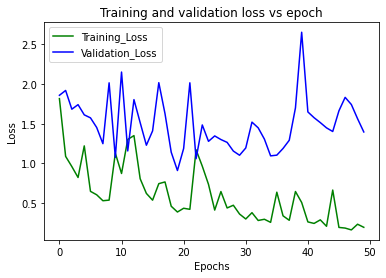

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(list(range(len(train_loss))), train_loss , 'g', label='Training_Loss')
plt.plot(list(range(len(val_loss))), val_loss, 'b', label='Validation_Loss')
plt.title('Training and validation loss vs epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss.png')

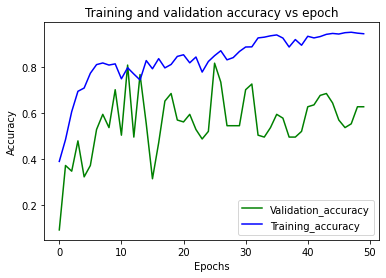

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(list(range(len(val_acc))), val_acc , 'g', label='Validation_accuracy')
plt.plot(list(range(len(train_acc))), train_acc, 'b', label='Training_accuracy')
plt.title('Training and validation accuracy vs epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('acc.png')

SAVE MODEL-

In [ ]:
torch.save(model, '/content/drive/MyDrive/IE643_Challenge/test_model')

LOAD MODEL-

In [ ]:
#Run this to make sure that the model to be uploaded is defined.
import torch.nn as nn

class Audio_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear(11025, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 7),

        )

    def forward(self, input):
        return self.model(input)

In [ ]:
#Please make sure that the model class is defined.
#Update with the location of the model
model = torch.load('/content/drive/MyDrive/IE643_Challenge/test_model.pt')

# TESTING PHASE

It is assumed that all audio test files are sampled at 44.1 kHz.

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
output_dir = '/content/private_data'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for i in range(1,8):
  os.makedirs(os.path.join(output_dir, str(i)))

Folder for storing the private dataset has been created, please upload the test data samples into their respective labelled folder.

Else, if private test dataset is similar in format to the provided input dataset, please paste it's path in "output_dir" variable.

In [ ]:
#Code for checking individual samples
def test_sample(aud_file):
  # if path =True:
  #   aud_fileorpath=librosa.load(aud_fileorpath, sr=None)
  count=0
  audio_feat, audio_clips, sample_count=preprocess(aud_file)
  ind_pred=[]
  for i in range(sample_count):
    input=torch.tensor(audio_feat[i][0]).to(device)
    input=input.view(-1)   
    ind_pred.append(torch.argmax(model(input)).item())
    model_pred=  max(ind_pred, key=ind_pred.count)    
  return model_pred


In [ ]:
#Function that evaluates the performance of the model on the data
def eval_perf(private_test_data):
    tot_count=0
    count=0
    y_pred=[]
    y_true=[]
    for i in range(len(private_test_data)):
      for aud in (private_test_data[i]):
        model_pred=test_sample(aud[0])
        y_pred.append(model_pred)
        y_true.append(aud[1])
        if model_pred == aud[1]:
          count +=1
      tot_count += len(private_test_data[i])

    cm=confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[1,2,3,4,5,6,7])
    disp.plot()
    #plt.show()
    plt.savefig('conf_mat.png')

    print('total number of samples {}, number of correct predictions is {}'.format(tot_count, count))
    print('Accuracy of model on given dataset ', count/tot_count)
    print('Precision ', precision_score(y_true, y_pred, average='micro'))
    print('Recall ', recall_score(y_true, y_pred, average='micro'))
    # print('Confusion matrix ', confusion_matrix(y_true, y_pred) )


In [ ]:
#For checking
#output_dir = '/content/drive/MyDrive/IE643_Challenge/challenge_dataset.zip (Unzipped Files)/challenge_dataset'

In [ ]:
#Code to create test data
priv_test_data=[]
for fil in os.listdir(output_dir):
  label=int(fil)-1
  ind_class=[]
  if (len(os.listdir(os.path.join(output_dir, fil))) != 0):
    for sample in os.listdir(os.path.join(output_dir, fil)):
      audio_file=librosa.load(os.path.join(output_dir, fil, sample), sr=None)      #Sampling rate is the default sampling rate used in the .wav input file
      ind_class.append([[audio_file[0], audio_file[1]], label])     #audio_file[0]---array containing audio, audio_file[1]---sampling rate of the audio clip
    priv_test_data.append(ind_class)

total number of samples 119, number of correct predictions is 110
Accuracy of model on given dataset  0.9243697478991597
Precision  0.9243697478991597
Recall  0.9243697478991597


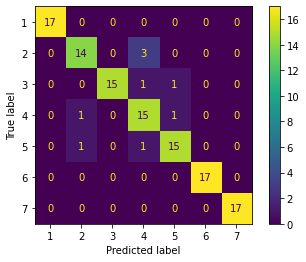

In [ ]:
#For checking purposes (since the private test data is not accessible),
#priv_test_data has been set to the entire given dataset (i.e, train + eval)
#this is set 2 code blocks above
#here we evaluate the performance of the model on the (train + eval) dataset
eval_perf(priv_test_data)

total number of samples 105, number of correct predictions is 101
Accuracy of model on given dataset  0.9619047619047619
Precision  0.9619047619047619
Recall  0.9619047619047619


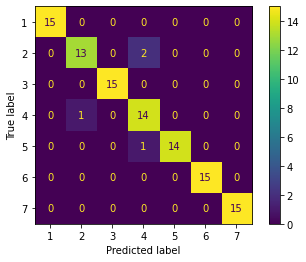

In [ ]:
eval_perf(train_set)

Utility Code for testing single files: (Not required)

In [ ]:
#Code to read single audio file from certain path.
file_path='/content/5-160614-B-48.wav'
audio_file=librosa.load(file_path, sr=None)
audio_feat, audio_clips, sample_count=preprocess(audio_file)
sample_count         

19

In [ ]:
#Alternate code to check a particular audio clip in test_data_file
cat=2   #To check particular clip of certain category
audio_feat, audio_clips, sample_count=preprocess(train_set[cat][0][0])    #train_set[category][sample number][0]
sample_count   

1

In [ ]:
play(train_set[cat][0][0])

In [ ]:
n=3
ipd.Audio(audio_clips[n][0], rate=audio_clips[n][1])

In [ ]:
      for n in range(len(audio_feat)):
        input=torch.tensor(audio_feat[n][0]).to(device)
        input=input.view(-1)
        print('for', n, (model(input)))
        #print('for', n, torch.argmax(model(input)))